In [25]:
# === 1. Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
import shap
import warnings
warnings.filterwarnings("ignore")

# === 2. Load Data ===
df = pd.read_csv("heart-attack-risk-prediction-dataset.csv")

# Display basic info
df.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Heart Attack Risk (Text),Gender,Systolic blood pressure,Diastolic blood pressure
0,0.595506,0.314286,0.047663,0.0,0.0,1.0,0.0,0.0,0.208326,0,...,0.0,0.333333,0.0,0.227018,0.048229,0.036512,0,Male,0.600000,0.534884
1,0.595506,0.096429,0.047663,1.0,1.0,1.0,1.0,1.0,0.752420,1,...,2.0,0.666667,0.0,0.227018,0.048229,0.036512,0,Male,0.574194,0.569767
2,0.595506,0.189286,0.047663,0.0,0.0,1.0,0.0,1.0,0.200998,2,...,4.0,1.000000,0.0,0.227018,0.048229,0.036512,0,Male,0.187097,0.674419
3,0.078652,0.960714,0.071494,1.0,1.0,1.0,1.0,1.0,0.090557,2,...,1.0,0.500000,0.0,0.227018,0.048229,0.036512,0,Male,0.645161,0.593023
4,0.078652,0.792857,0.071494,1.0,0.0,1.0,1.0,0.0,0.601030,2,...,1.0,0.166667,0.0,0.227018,0.048229,0.036512,0,Male,0.251613,0.383721


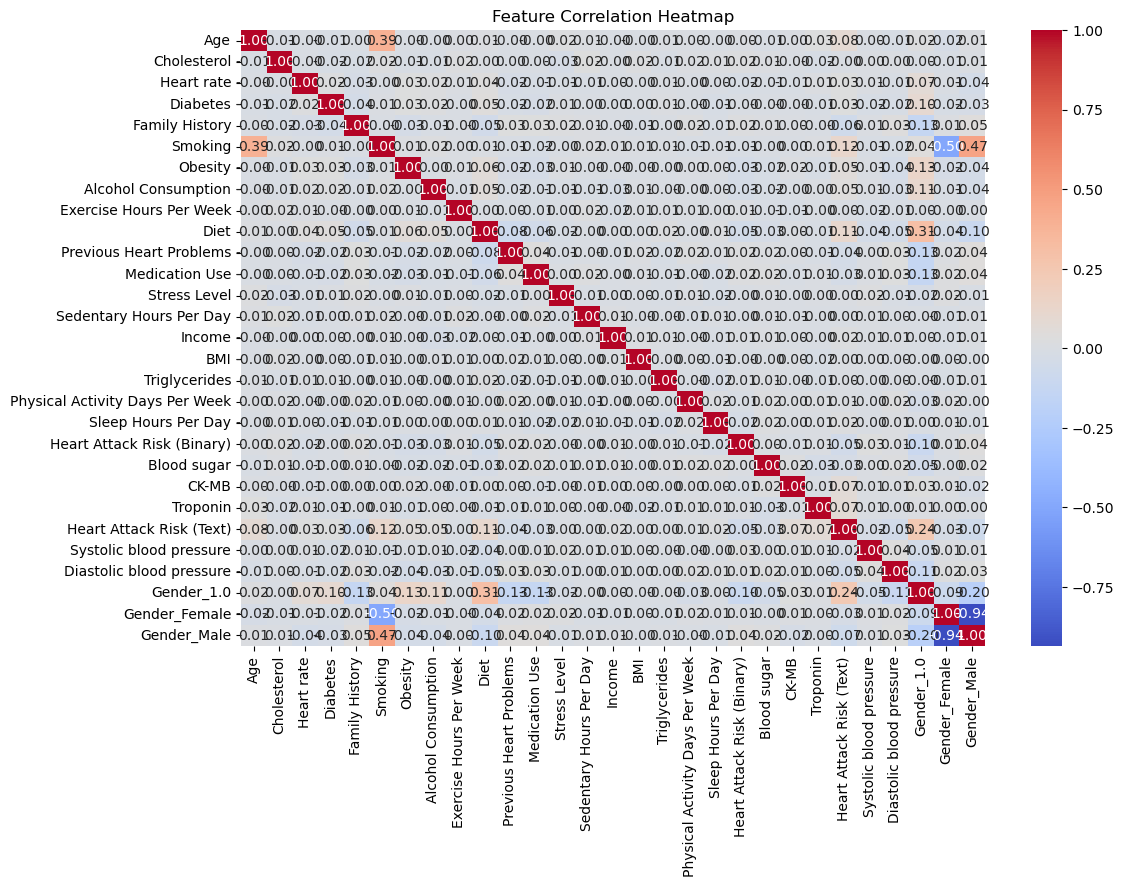

In [26]:
# === 3. Preprocessing ===
# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# Convert categorical variables to dummies
df = pd.get_dummies(df, drop_first=True)

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()


In [27]:
# === 4. Feature Selection and Balancing ===
target_column = "Heart Attack Risk (Binary)"
X = df.drop(columns=[target_column, "Heart Attack Risk (Text)"])
y = df[target_column]

# Class balance with SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [28]:
# === 5. Train and Evaluate Function ===
def train_and_evaluate(model, name):
    print(f"\n==== {name} Evaluation ====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    return model


==== XGBoost Evaluation ====
XGBoost Accuracy: 0.7289
              precision    recall  f1-score   support

         0.0       0.70      0.80      0.75      1210
         1.0       0.77      0.66      0.71      1210

    accuracy                           0.73      2420
   macro avg       0.73      0.73      0.73      2420
weighted avg       0.73      0.73      0.73      2420



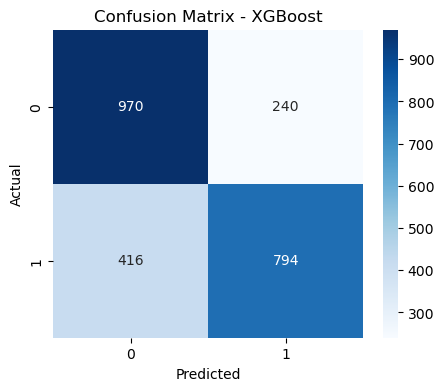


==== Random Forest Evaluation ====
Random Forest Accuracy: 0.7591
              precision    recall  f1-score   support

         0.0       0.72      0.85      0.78      1210
         1.0       0.82      0.67      0.73      1210

    accuracy                           0.76      2420
   macro avg       0.77      0.76      0.76      2420
weighted avg       0.77      0.76      0.76      2420



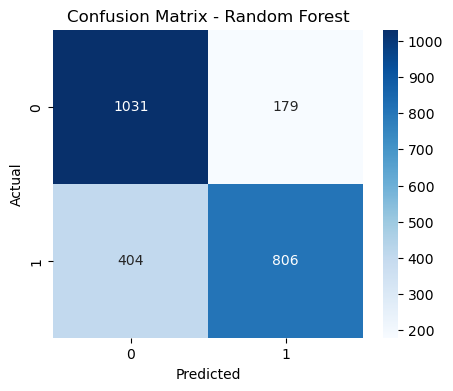

In [29]:
# === 6. Train Models ===
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb = train_and_evaluate(xgb, "XGBoost")

rf = RandomForestClassifier(random_state=42)
rf = train_and_evaluate(rf, "Random Forest")


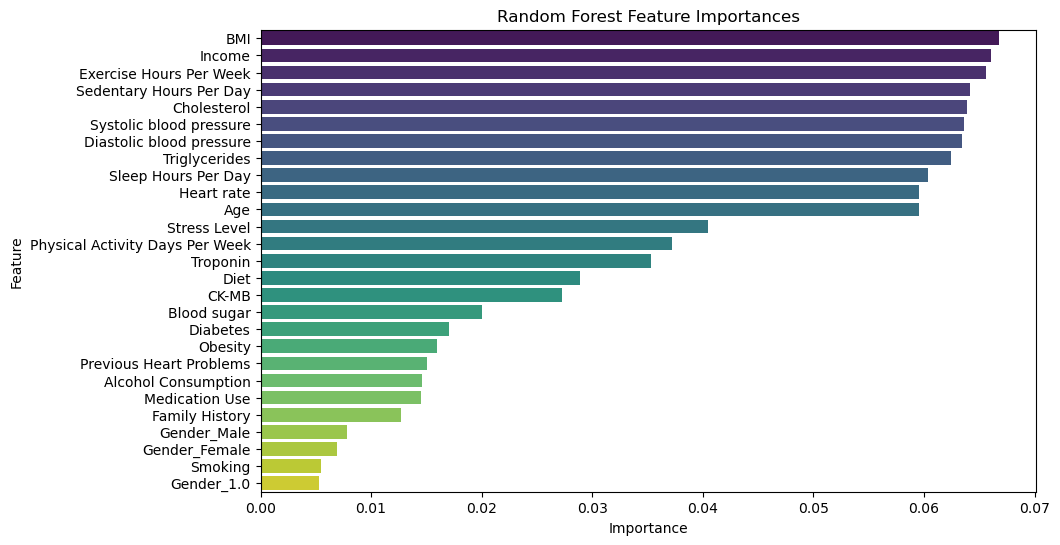

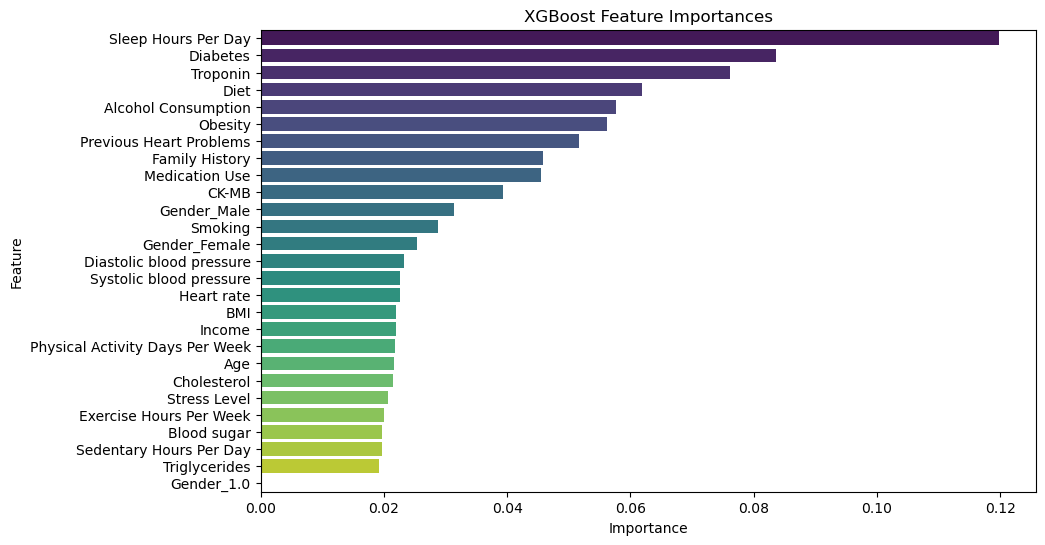

In [30]:
# === 7. Feature Importances ===
def plot_feature_importance(model, X, name):
    importances = model.feature_importances_
    indices = importances.argsort()[::-1]
    features = X.columns[indices]
    values = importances[indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=values, y=features, palette='viridis')
    plt.title(f'{name} Feature Importances')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# Reuse original column names
X_unscaled = df.drop(columns=[target_column, "Heart Attack Risk (Text)"])
plot_feature_importance(rf, X_unscaled, "Random Forest")
plot_feature_importance(xgb, X_unscaled, "XGBoost")


Generating SHAP explanations...


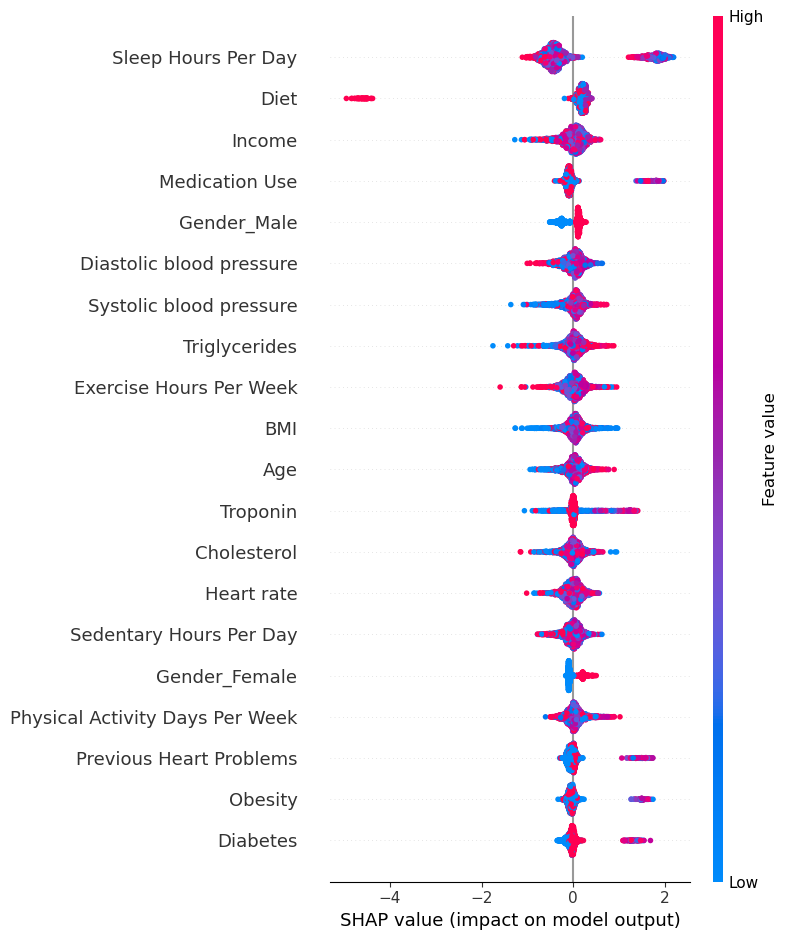

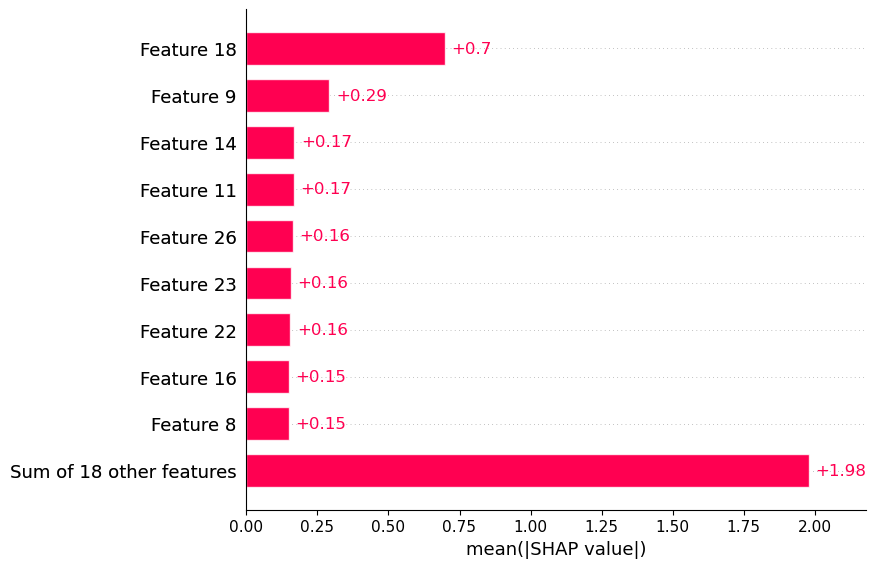

In [31]:
# === 8. SHAP Explainability ===
print("Generating SHAP explanations...")
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, features=X_test, feature_names=X_unscaled.columns)

# Bar plot
shap.plots.bar(shap_values)


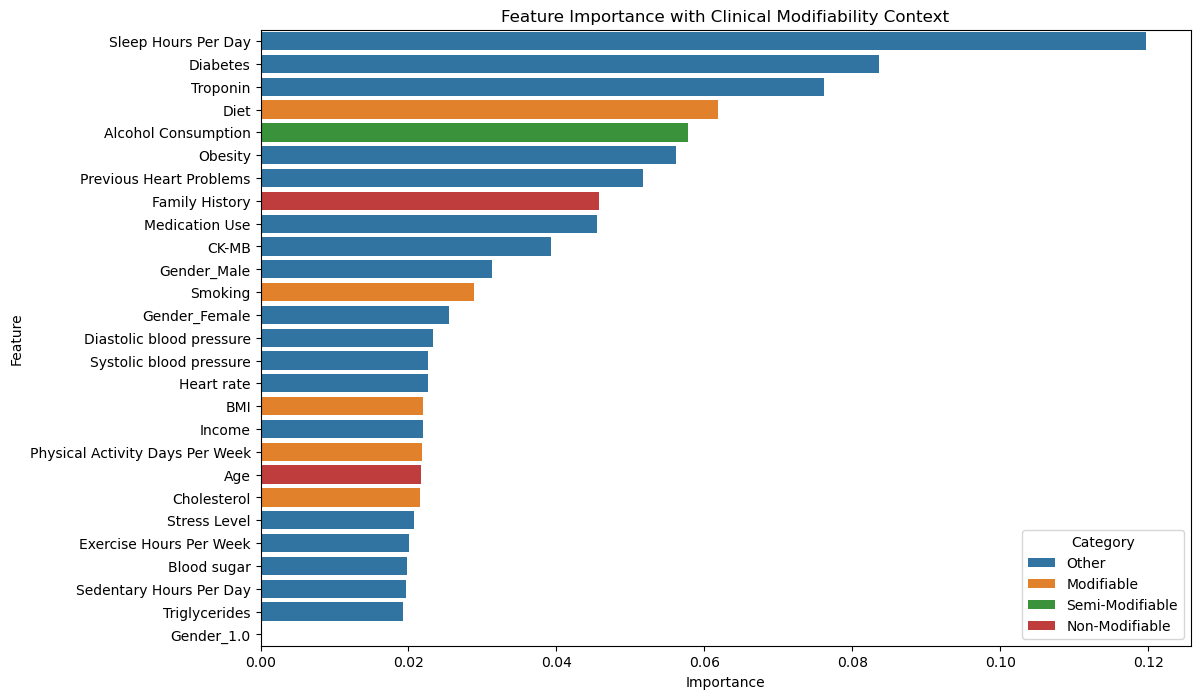

,Feature,Importance,Category
0,Age,0.021715,Non-Modifiable
1,Cholesterol,0.021509,Modifiable
2,Heart rate,0.022573,Other
3,Diabetes,0.083532,Other
4,Family History,0.045762,Non-Modifiable
5,Smoking,0.028804,Modifiable
6,Obesity,0.056192,Other
7,Alcohol Consumption,0.057728,Semi-Modifiable
8,Exercise Hours Per Week,0.020091,Other
9,Diet,0.061858,Modifiable


In [32]:

# Clinical Context for Features: Categorizing risk factors by modifiability, making results more actionable.
def clinical_feature_analysis(feature_importances, feature_names):
    # Define modifiability of risk factors
    modifiable = ['Cholesterol', 'Blood Pressure', 'BMI', 'Smoking', 'Physical Activity', 'Diet']
    semi_modifiable = ['Sleep Apnea', 'Stress Levels', 'Alcohol Consumption']
    non_modifiable = ['Age', 'Sex', 'Family History', 'Genetic Markers']
    
    # Categorize features
    feature_categories = {}
    for feature in feature_names:
        if any(m in feature for m in modifiable):
            feature_categories[feature] = 'Modifiable'
        elif any(s in feature for s in semi_modifiable):
            feature_categories[feature] = 'Semi-Modifiable'
        elif any(n in feature for n in non_modifiable):
            feature_categories[feature] = 'Non-Modifiable'
        else:
            feature_categories[feature] = 'Other'
    
    # Create DataFrame for plotting
    df_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances,
        'Category': [feature_categories[f] for f in feature_names]
    })
    
    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', hue='Category', data=df_imp.sort_values('Importance', ascending=False))
    plt.title('Feature Importance with Clinical Modifiability Context')
    plt.show()
    
    return df_imp

# Apply to your feature importances
clinical_feature_analysis(xgb.feature_importances_, X_unscaled.columns)

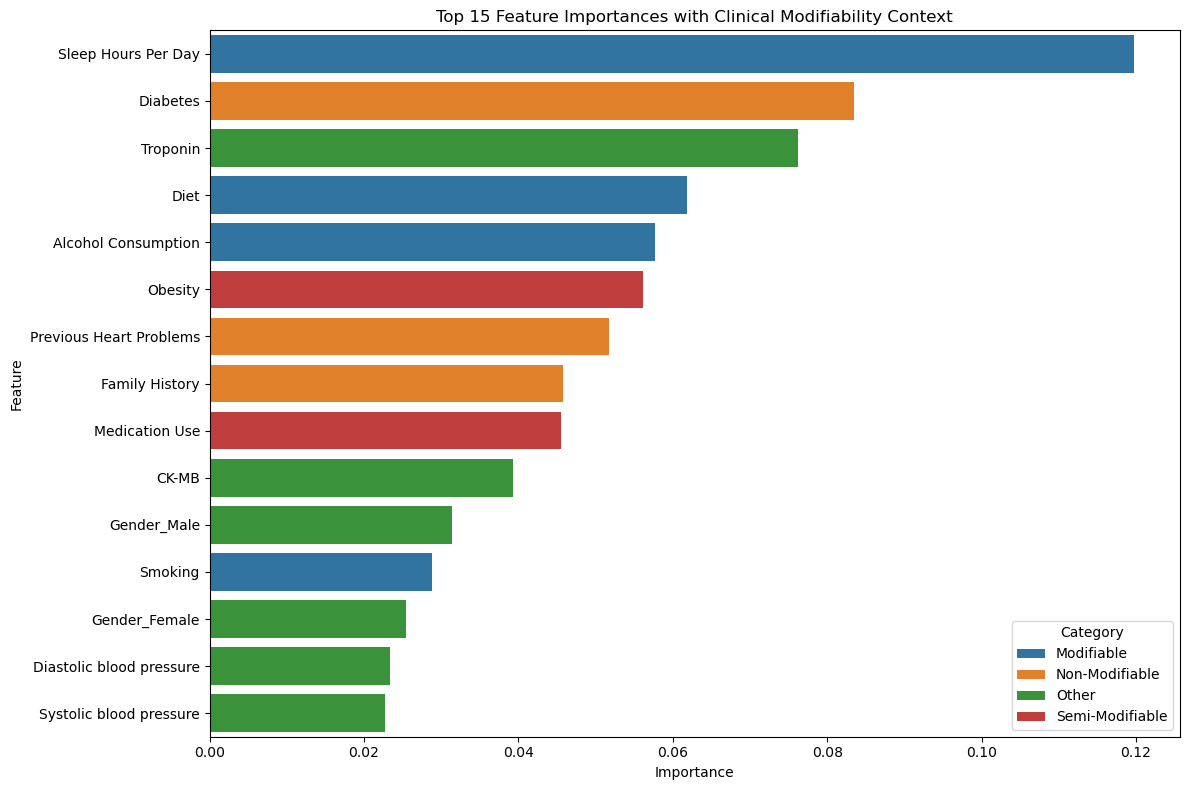

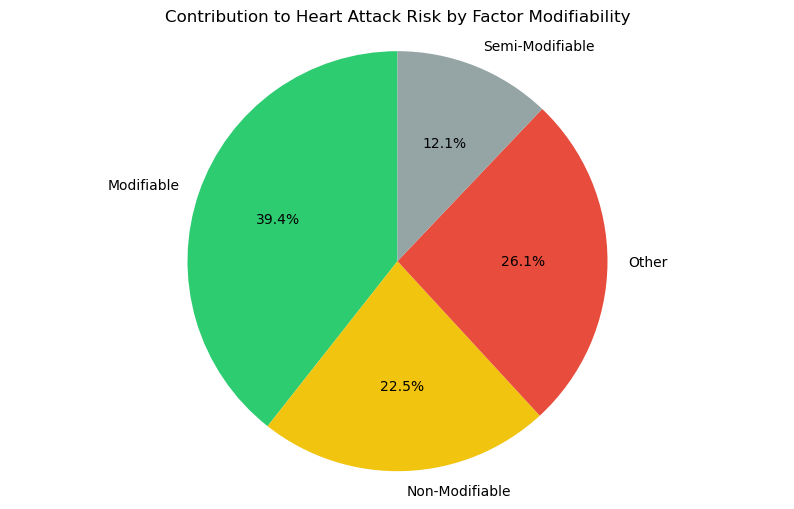


Actionability Score: 0.45
Higher score means more potential for risk reduction through lifestyle interventions

Top Modifiable Risk Factors:
- Sleep Hours Per Day (Importance: 0.1197)
- Diet (Importance: 0.0619)
- Alcohol Consumption (Importance: 0.0577)
- Smoking (Importance: 0.0288)
- BMI (Importance: 0.0219)


In [23]:
# === 10. Clinical Context Feature Analysis ===
def clinical_feature_analysis(model, feature_names):
    """
    Analyze feature importance in clinical context by categorizing risk factors
    based on their modifiability
    """
    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        # For models without feature_importances_ attribute
        importances = [0] * len(feature_names)
    
    # Define modifiability categories for risk factors
    modifiable = [
        'Cholesterol', 'Blood Pressure', 'BMI', 'Diet', 'Exercise', 
        'Smoking', 'Alcohol', 'Physical Activity', 'Stress Level',
        'Sedentary Hours', 'Sleep Hours'
    ]
    
    semi_modifiable = [
        'Medication Use', 'Obesity', 'Heart Rate', 'Triglycerides'
    ]
    
    non_modifiable = [
        'Age', 'Sex', 'Family History', 'Previous Heart Problems', 
        'Diabetes', 'Income'
    ]
    
    # Categorize each feature
    feature_categories = []
    for feature in feature_names:
        if any(factor in feature for factor in modifiable):
            category = 'Modifiable'
        elif any(factor in feature for factor in semi_modifiable):
            category = 'Semi-Modifiable'
        elif any(factor in feature for factor in non_modifiable):
            category = 'Non-Modifiable'
        else:
            category = 'Other'
        feature_categories.append(category)
    
    # Create DataFrame with feature info
    feature_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances,
        'Category': feature_categories
    })
    
    # Sort by importance
    feature_df = feature_df.sort_values('Importance', ascending=False)
    
    # Calculate importance by category
    category_importance = feature_df.groupby('Category')['Importance'].sum().reset_index()
    
    # Plot feature importance with clinical context
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', hue='Category', data=feature_df.head(15))
    plt.title('Top 15 Feature Importances with Clinical Modifiability Context')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    # Plot categorical pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(category_importance['Importance'], 
            labels=category_importance['Category'],
            autopct='%1.1f%%', 
            startangle=90,
            colors=['#2ecc71', '#f1c40f', '#e74c3c', '#95a5a6'])
    plt.title('Contribution to Heart Attack Risk by Factor Modifiability')
    plt.axis('equal')
    plt.show()
    
    # Create actionability score
    # Higher score = more potential for risk reduction through interventions
    actionability_score = (
        category_importance[category_importance['Category'] == 'Modifiable']['Importance'].sum() +
        0.5 * category_importance[category_importance['Category'] == 'Semi-Modifiable']['Importance'].sum()
    ) / category_importance['Importance'].sum()
    
    print(f"\nActionability Score: {actionability_score:.2f}")
    print("Higher score means more potential for risk reduction through lifestyle interventions")
    
    # Return categorized features
    return feature_df

# Run clinical feature analysis
clinical_features = clinical_feature_analysis(xgb, X_unscaled.columns)

# Display top modifiable risk factors
print("\nTop Modifiable Risk Factors:")
top_modifiable = clinical_features[clinical_features['Category'] == 'Modifiable'].head(5)
for i, row in top_modifiable.iterrows():
    print(f"- {row['Feature']} (Importance: {row['Importance']:.4f})")

In [36]:
# === 9. Clinical Context for Features ===
modifiable = ['Cholesterol', 'Resting BP', 'Max HR', 'Exercise Angina_Yes', 'Oldpeak']
non_modifiable = ['Age', 'Sex_M', 'Chest Pain Type_typical angina']

print("🩺 Modifiable Features:", modifiable)
print("🧬 Non-modifiable Features:", non_modifiable)

# === 10. Personalized Risk Scoring ===
def predict_individual_risk(input_data, model):
    df_input = pd.DataFrame([input_data])
    df_input = pd.get_dummies(df_input)
    df_input = df_input.reindex(columns=X_unscaled.columns, fill_value=0)  # ensure same shape
    df_input_scaled = scaler.transform(df_input)
    
    prediction = model.predict(df_input_scaled)[0]
    proba = model.predict_proba(df_input_scaled)[0][1]
    
    print("\n🎯 Personalized Risk Prediction")
    print(f"➡️  Predicted Risk Class: {'High' if prediction == 1 else 'Low'}")
    print(f"🔢 Predicted Probability of Heart Attack: {proba:.2%}")
    
    # SHAP Force Plot
    shap_values = explainer(df_input_scaled)
    shap.plots.force(shap_values[0])

# EXAMPLE:
individual_example = {
    'Age': 58,
    'Sex_M': 1,
    'Cholesterol': 250,
    'Resting BP': 140,
    'Max HR': 120,
    'Exercise Angina_Yes': 1,
    'Oldpeak': 2.3,
    'Chest Pain Type_typical angina': 1,
}
predict_individual_risk(individual_example, xgb)

🩺 Modifiable Features: ['Cholesterol', 'Resting BP', 'Max HR', 'Exercise Angina_Yes', 'Oldpeak']
🧬 Non-modifiable Features: ['Age', 'Sex_M', 'Chest Pain Type_typical angina']

🎯 Personalized Risk Prediction
➡️  Predicted Risk Class: Low
🔢 Predicted Probability of Heart Attack: 25.39%
